
Branin: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 39.0 MB/s 
     |████████████████████████████████| 872 kB 48.7 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=91e34f7eea3731c4f7ad270eb9dffaf1edd0d599b5ccb3540aece34fd344bdc5
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=641e81c5306c8801e487769ac9ec9a759d234a347f7ba332859130b1ebca5334
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds          


In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]
    
    def CBM(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, y_global_orig, mean, std, ds, dm, nu=3.0):
    
        return self.f(y_global_orig, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1662465643.0694306

In [13]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 5.487345388111518	 5.638236201098191
2  	 [10.         14.16092673]	 126.44343791451641	 5.089934878453152	 5.928821279372821	 5.856547305810691
3  	 [-5.         13.92397282]	 23.37345137829523	 5.089934878453152	 5.57939500863289	 5.778702148513889
4  	 [6.79355721 7.61512393]	 60.17762503867417	 5.089934878453152	 6.213268493779486	 5.858536178472616
5  	 [3.17718006 0.        ]	 5.454820775263954	 5.089934878453

In [14]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 5.699296112273292	 6.2656429343994935
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 5.48608907147091	 5.945618087687977
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 5.670307053814476	 6.197392880424498
4  	 [-5. 15.]	 17.508299515778166	 1.3984593420568778	 5.334535783520369	 5.916754711241988
5  	 [-5.          0.51965784]	 290.53604781113035	 1.3984593420568778	 5.8

In [15]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 4.241477993385701	 4.241477993385701
2	 [-5. 15.]	 17.508299515778166	 17.508299515778166	 5.2564550840142985	 6.2012368106014595
3	 [2.4586388  0.51525427]	 8.086293584852344	 8.086293584852344	 5.745660409445073	 6.3888172333850966
4  	 [10.  0.]	 10.960889035651505	 8.086293584852344	 5.103627276317719	 5.361358990035534
5  	 [ 0.18293364 15.        ]	 105.6870090980543	 8.086293584852344	 6.005631599940793	 6.

In [16]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [ 1.25164457 13.57001383]	 100.61648848019335	 7.247126865776948	 5.390263030922341	 5.919880045578209
2  	 [-5.  0.]	 308.12909601160663	 7.247126865776948	 6.099949388179886	 5.822837001886807
3  	 [-5. 15.]	 17.508299515778166	 7.247126865776948	 5.203988777409145	 6.280061428215341
4  	 [1.01757851 0.        ]	 35.42357667162813	 7.247126865776948	 4.978464820941859	 5.5637437151336835
5  	 [3.93173896 8.52680458]	 49.31076408226815	 7.247126865776948	 5.324312300510104	 5.7383

In [17]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 6.223759599255244	 6.2359000844198516
2  	 [10. 15.]	 145.87219087939556	 5.96108856337545	 5.8941219609869515	 5.80338968742424
3  	 [-4.09465254  7.88822372]	 50.60443301918567	 5.96108856337545	 5.766618835967077	 6.387438696998517
4  	 [ 3.7099837 15.       ]	 174.2134239091822	 5.96108856337545	 5.522541289316693	 5.541963940063479
5  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.52336509940713	 5.83062

In [18]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [ 9.64829531 12.55362889]	 98.32295673962142	 15.31731051317483	 5.174553622864057	 5.569250053127693
2  	 [-5.  0.]	 308.12909601160663	 15.31731051317483	 5.847991679953253	 6.520379131936597
3  	 [ 4.34724927 14.59608757]	 177.48889452505895	 15.31731051317483	 5.429123615264638	 5.424438967270725
4  	 [-2.30273961 14.72568636]	 22.729915390731268	 15.31731051317483	 5.769274682377704	 6.364700519621058
5  	 [1.62895493 0.13431773]	 22.516676732879368	 15.31731051317483	 5.56787

In [19]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 4.234605889855404	 4.835344351454883
2  	 [ 8.91691628 15.        ]	 168.53807473378885	 5.211335324193094	 5.718156807566418	 5.786424194210805
3  	 [10.  0.]	 10.960889035651505	 5.211335324193094	 5.3610362771592674	 5.4468669804978775
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 4.5131580412656405	 4.684343925138193
5  	 [4.55506611 5.90016308]	 28.47090228991144	 5.211335324193094	 4.8

In [20]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1  	 [-5. 15.]	 17.508299515778166	 15.416245468470875	 5.180498456596191	 5.67128248806313
2	 [10.  0.]	 10.960889035651505	 10.960889035651505	 5.7417731744460205	 5.578652913455975
3  	 [-5.          8.10742832]	 95.1689133971982	 10.960889035651505	 5.533382058755044	 6.125583910615789
4  	 [ 1.62597918 12.87048713]	 92.5859704591356	 10.960889035651505	 5.4783526502083655	 5.510259106046607
5	 [4.58008245 1.1608382 ]	 8.800703127896494	 8.800703127896494	 5.511009081585937	 5

In [21]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 5.715468862777009	 5.393626374593891
2  	 [9.79317275 0.        ]	 8.900510263400083	 3.4640248583909496	 5.454381791145676	 4.857053843266392
3  	 [-1.64804202 15.        ]	 45.573969859593134	 3.4640248583909496	 4.940764903679022	 5.106231550120049
4  	 [7.95596725 8.39803319]	 56.402277607584324	 3.4640248583909496	 5.217582367312017	 4.8521486906039
5  	 [0.84336607 9.67882349]	 40.68193894094502	 3.4640

In [22]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [10.          6.65759109]	 15.299493898244622	 2.710610964564512	 4.779484637188568	 5.231927077429423
2  	 [-3.9785409   6.96796212]	 58.461200561224906	 2.710610964564512	 4.501359007505147	 5.14207457586981
3  	 [-5. 15.]	 17.508299515778166	 2.710610964564512	 4.785212096600508	 4.857278629261883
4  	 [10. 15.]	 145.87219087939556	 2.710610964564512	 5.772994435839321	 5.7308062389596675
5  	 [ 1.03409033 15.        ]	 125.32062520488041	 2.710610964564512	 5.488225609284402

In [23]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [7.58042751 0.        ]	 14.440095631532731	 14.440095631532731	 4.975582711076718	 5.471050216974576
2	 [-3.69185194 13.22643636]	 1.9834337577905252	 1.9834337577905252	 4.950351363323038	 5.616107302626337
3  	 [9.48896345 5.36683862]	 8.467162742850146	 1.9834337577905252	 5.105479468863799	 5.683202641501485
4	 [2.94351693 2.23003407]	 0.6274594292191651	 0.6274594292191651	 4.47332227696996	 4.206399054572537
5  	 [ 4.54032206 15.        ]	 192.31279651743571	 0.6274594292

In [24]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [10.          5.12551017]	 6.448374278894724	 0.5499315281120278	 4.57955228668599	 4.26826945545409
2  	 [ 8.50155249 13.79797306]	 148.00655208378976	 0.5499315281120278	 4.972668507092401	 4.446310442304586
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 5.2254769855260434	 5.154791069908095
4  	 [1.40497299 1.94456046]	 15.88793348974972	 0.5499315281120278	 4.341857713904268	 4.370353422365306
5  	 [ 2.40752628 15.        ]	 148.86780589756196	 

In [25]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-5.         10.31766196]	 59.91650583997099	 18.038943061558626	 5.566732936358889	 5.9413861559801555
2  	 [-3.36042638  1.3238031 ]	 132.49290788011677	 18.038943061558626	 4.878572979081707	 5.113150603608808
3  	 [-1.32517746 15.        ]	 56.744436908264824	 18.038943061558626	 5.708591282040219	 5.4389817352481415
4  	 [-0.05793037  6.91772942]	 20.26678994480263	 18.038943061558626	 5.7849378063229056	 5.161423922319001
5	 [2.40890242 0.        ]	 11.36357856878570

In [26]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [-5.  0.]	 308.12909601160663	 1.4149920024014744	 5.344260027455295	 5.466010029221133
2  	 [-3.61083748  7.85924032]	 32.481990179851884	 1.4149920024014744	 5.596549685398266	 5.741433099875428
3  	 [10. 15.]	 145.87219087939556	 1.4149920024014744	 5.4513404316380525	 5.724342576253134
4  	 [10.          6.35018654]	 13.147088917781499	 1.4149920024014744	 4.2008192655282555	 4.292895074568326
5  	 [-5.         12.64208214]	 33.38330604824482	 1.4149920024014744	 4.4313665

In [27]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [ 6.5655417  11.87699252]	 134.95011349993544	 12.768724532005583	 5.155210804211745	 5.226282353167729
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 5.684681292683775	 6.141043192207497
3  	 [ 0.94011255 15.        ]	 123.44952529905613	 12.768724532005583	 6.137457947608504	 6.19973484149697
4	 [2.80352573 0.        ]	 7.461287931728957	 7.461287931728957	 5.2023969277964595	 5.33319891434613
5  	 [10.          7.37065371]	 21.019918630553953	

In [28]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 5.617895548228122	 5.55495043443419
2  	 [-4.93881036  0.        ]	 301.5436542870195	 2.715864006988424	 5.975158833947352	 5.509467186399391
3  	 [10.          5.77335478]	 9.61824668798663	 2.715864006988424	 5.147699142248793	 5.521160909730466
4  	 [4.50737323 8.15773465]	 53.02736353097579	 2.715864006988424	 5.241741543092047	 5.495930762278785
5  	 [10.  0.]	 10.960889035651505	 2.715864006988424	 5.14561963

In [29]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [-5. 15.]	 17.508299515778166	 17.508299515778166	 6.338118227567892	 7.345494624271939
2	 [9.21884529 1.9502252 ]	 0.7278974407260215	 0.7278974407260215	 5.132020510274362	 5.255110294844715
3  	 [3.74599703 2.35814314]	 2.3563457989420957	 0.7278974407260215	 5.325888282010876	 4.739082276876932
4  	 [10. 15.]	 145.87219087939556	 0.7278974407260215	 5.975579397076501	 5.938738476081098
5  	 [ 1.85124958 13.87047323]	 114.96410766748436	 0.7278974407260215	 5.1353120500913

In [30]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1	 [-2.12483893 10.71385111]	 5.508754856016457	 5.508754856016457	 5.710337807030586	 6.37940636957513
2  	 [-5.          4.89130832]	 163.91664037564146	 5.508754856016457	 5.6014265888181525	 6.381530953225514
3  	 [-5. 15.]	 17.508299515778166	 5.508754856016457	 5.375289499110995	 5.49146395351071
4  	 [4.16851746 0.        ]	 7.6246772695839535	 5.508754856016457	 5.870580633677289	 5.518174198662103
5  	 [10. 15.]	 145.87219087939556	 5.508754856016457	 4.648442033763442	 4.5

In [31]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1  	 [10.  0.]	 10.960889035651505	 4.475608269502271	 5.312941014001845	 5.633500459449604
2  	 [6.23642763 4.30889573]	 29.89637063468267	 4.475608269502271	 6.078022320433314	 6.341730212886069
3  	 [1.2359647  7.48630051]	 23.757252607738565	 4.475608269502271	 5.663393392254727	 5.922450951220167
4  	 [-5.          6.34642841]	 130.24955145602638	 4.475608269502271	 6.412267759162195	 6.3426024422465765
5  	 [ 0.07412016 15.        ]	 102.70010913520753	 4.475608269502271	 5.44

In [32]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-5.  0.]	 308.12909601160663	 14.042667401507376	 5.524120124361175	 5.6990742893349475
2	 [9.63618477 0.        ]	 7.682473717352852	 7.682473717352852	 4.909228745412954	 5.274382485486591
3  	 [9.76590761 5.78142624]	 9.973058028578054	 7.682473717352852	 4.907747055381924	 4.727452853711354
4  	 [-5. 15.]	 17.508299515778166	 7.682473717352852	 5.483095986667051	 6.787871397803503
5  	 [0.7109862 0.       ]	 41.61742393663327	 7.682473717352852	 5.383491788186178	 5.1

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1662466123.9947371

In [34]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 5.487345388111518	 5.638236201098191
2  	 [10. 15.]	 145.87219087939556	 5.089934878453152	 5.928821279372821	 5.856547305810691
3  	 [9.50914495 8.52150693]	 36.125759150808236	 5.089934878453152	 5.595824932172363	 5.786812721766366
4  	 [-4.67712792 14.21955317]	 13.865244792739254	 5.089934878453152	 6.3366110131166575	 6.717207526978829
5  	 [3.28229494 0.        ]	 5.192262582834574	 5.089934878453152	 4.81391

In [35]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 5.699296112273292	 6.2656429343994935
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 5.48608907147091	 5.945618087687977
3  	 [ 3.49465529 14.66255293]	 160.93143085551043	 1.3984593420568778	 5.670307053814476	 6.197392880424498
4  	 [-5.  0.]	 308.12909601160663	 1.3984593420568778	 5.2012585692033095	 6.089885223686244
5  	 [9.00136961 6.35944099]	 19.041010249359367	 1.3984593420568778	 5.62

In [36]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 4.241477993385701	 4.241477993385701
2	 [-3.89564496 13.38589781]	 3.6010193697779265	 3.6010193697779265	 5.2564550840142985	 6.2012368106014595
3  	 [ 0.70821102 15.        ]	 118.54412423340214	 3.6010193697779265	 5.802823062655096	 6.843170679802499
4  	 [2.62008229 0.69770342]	 5.751228082851562	 3.6010193697779265	 5.047319827864031	 4.933765472897235
5  	 [9.90066241 8.47951257]	 32.532469069472825	 3.6010

In [37]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [ 1.25164457 13.57001383]	 100.61648848019335	 7.247126865776948	 5.390263030922341	 5.919880045578209
2  	 [-5.  0.]	 308.12909601160663	 7.247126865776948	 6.099949388179886	 5.822837001886807
3  	 [0.98905024 0.        ]	 35.9991709240805	 7.247126865776948	 5.203988777409145	 6.280061428215341
4  	 [3.23188099 8.99676659]	 46.556386793162574	 7.247126865776948	 4.924031606329941	 5.647177710844571
5  	 [-4.73699493 13.33053872]	 19.892240270122997	 7.247126865776948	 5.34920168

In [38]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 6.223759599255244	 6.2359000844198516
2  	 [10. 15.]	 145.87219087939556	 5.96108856337545	 5.8941219609869515	 5.80338968742424
3  	 [-4.08235388  8.01908103]	 48.314525731401304	 5.96108856337545	 5.766618835967077	 6.387438696998517
4  	 [ 3.65601665 14.99496466]	 172.9090613940532	 5.96108856337545	 5.523520948897699	 5.542700509898628
5  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.551137912508089	 5.8

In [39]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [10. 15.]	 145.87219087939556	 15.31731051317483	 5.174553622864057	 5.569250053127693
2  	 [-3.60256696  0.        ]	 181.2358527670462	 15.31731051317483	 5.961746019301611	 5.855455456622813
3  	 [ 4.34724927 14.59608757]	 177.48889452505895	 15.31731051317483	 5.231974960650516	 5.242040262509791
4  	 [2.11574366 0.        ]	 15.332833934772548	 15.31731051317483	 5.849760128643216	 6.433447626682014
5  	 [-1.33539224 14.46151044]	 49.52030886646713	 15.31731051317483	 5.078881

In [40]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 4.234605889855404	 4.835344351454883
2  	 [10. 15.]	 145.87219087939556	 5.211335324193094	 5.718156807566418	 5.786424194210805
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.300757836748785	 5.735882313755242
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 4.513268393125206	 4.473998865395781
5  	 [4.94386051 5.50559887]	 29.981701145150826	 5.211335324193094	 4.924728

In [41]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 5.180498456596191	 5.67128248806313
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 5.8146353851136166	 5.535869689345445
3  	 [ 0.45044221 13.94601145]	 93.23695428764874	 6.499298445992174	 5.593481712095027	 6.413262111528751
4  	 [-3.69549212  5.14476421]	 74.10099475805737	 6.499298445992174	 5.487427495169764	 5.80721597144248
5  	 [ 4.44828169 11.29643831]	 103.9237780856966	 6.499298445

In [42]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 5.715468862777009	 5.393626374593891
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 5.454381791145676	 4.857053843266392
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 5.072833489954427	 5.043819881303748
4  	 [4.65772822 9.25206772]	 71.2941176700676	 3.4640248583909496	 5.048228996468545	 5.084017989163857
5  	 [10.        6.346655]	 13.12345964547641	 3.46402485

In [43]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [10.          5.65723525]	 8.988335765406656	 2.710610964564512	 4.779484637188568	 5.231927077429423
2  	 [-3.9785409   6.96796212]	 58.461200561224906	 2.710610964564512	 4.633655183108928	 5.214812063085423
3  	 [10.         13.94309377]	 121.62974185813269	 2.710610964564512	 4.675917468630762	 4.880595072693541
4  	 [ 0.84803315 15.        ]	 121.55299245559671	 2.710610964564512	 5.7346005053888565	 5.750885303065696
5  	 [-4.09915757 14.83384396]	 4.493216442058125	 2.710

In [44]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 4.975582711076718	 5.471050216974576
2	 [9.17949494 6.03788729]	 14.83805978369079	 14.83805978369079	 4.971014660722949	 5.6383646741241344
3  	 [ 4.55503167 15.        ]	 192.61838233843488	 14.83805978369079	 5.281740151626045	 6.351864777576404
4	 [2.25080808 2.66397836]	 4.128810901005437	 4.128810901005437	 4.504294068435051	 4.350043104285614
5	 [-2.78859355 11.96274991]	 1.2603462735579996	 1.26034627355799

In [45]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [10.          5.17418284]	 6.657364043671367	 0.5499315281120278	 4.57955228668599	 4.26826945545409
2  	 [ 8.50155249 13.79797306]	 148.00655208378976	 0.5499315281120278	 4.973741172444071	 4.448296979669593
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 5.22654788902761	 5.136419301058813
4  	 [2.7469577 0.       ]	 7.910911191741004	 0.5499315281120278	 4.343231273493836	 4.371673221690485
5  	 [4.4290729  8.00835539]	 49.86889015892532	 0.54993

In [46]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-5.          2.39871762]	 231.42769632807992	 18.038943061558626	 5.566732936358889	 5.9413861559801555
2	 [-3.06562888 11.40851515]	 0.8943531028899869	 0.8943531028899869	 5.356317949780224	 5.6217484878807245
3  	 [-0.14948749  6.02322162]	 19.542367332458138	 0.8943531028899869	 5.526472890104378	 5.5453978184026145
4  	 [-0.26333973 15.        ]	 92.7489556774061	 0.8943531028899869	 5.877756828933237	 6.026492371646551
5  	 [2.30706398 0.        ]	 12.64687466042722

In [47]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [-5.         1.0819993]	 272.1063957360596	 1.4149920024014744	 5.344260027455295	 5.466010029221133
2  	 [ 9.02510452 14.92575454]	 164.15736583327134	 1.4149920024014744	 5.55713710106284	 5.72937727664364
3  	 [-4.0509639  8.5721018]	 40.043984045668736	 1.4149920024014744	 4.948510827052573	 5.633046203933524
4  	 [8.19772537 6.72053896]	 32.63212233587686	 1.4149920024014744	 4.122730183652584	 4.6749022185662605
5  	 [-1.48881788  4.74008733]	 26.11967701913846	 1.414992

In [48]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [ 6.5655417  11.87699252]	 134.95011349993544	 12.768724532005583	 5.155210804211745	 5.226282353167729
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 5.684681292683775	 6.141043192207497
3  	 [ 1.00812085 14.79665801]	 120.5918911833693	 12.768724532005583	 6.137457947608504	 6.19973484149697
4	 [2.73090544 0.26234661]	 6.741042975340467	 6.741042975340467	 5.1998542075996115	 5.344234207341157
5  	 [9.99079035 7.40755314]	 21.37632344300185	 6.

In [49]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 5.617895548228122	 5.55495043443419
2  	 [9.92314199 8.33693272]	 30.82816637561242	 2.715864006988424	 5.975158833947352	 5.509467186399391
3  	 [-5.  0.]	 308.12909601160663	 2.715864006988424	 5.624816632633632	 5.560789932932955
4  	 [4.15024505 8.8379068 ]	 56.98279663310739	 2.715864006988424	 5.1463076109385195	 5.406788528120336
5  	 [ 0.8310123  11.57226008]	 62.78985808204933	 2.715864006988424	 5.16000505

In [50]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [9.76575296 0.98553483]	 4.1623278326263815	 4.1623278326263815	 6.338118227567892	 7.345494624271939
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 4.1623278326263815	 5.1386198306020185	 5.368052956972484
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 5.253686738440435	 4.986947524668276
4  	 [10. 15.]	 145.87219087939556	 2.3563457989420957	 6.253587235208989	 6.577360322125003
5  	 [-4.50675185 10.74029712]	 33.6051366965763	 2.3563457989420957	 5.

In [51]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1	 [-2.12483893 10.71385111]	 5.508754856016457	 5.508754856016457	 5.710337807030586	 6.37940636957513
2  	 [-4.62147141  5.94251158]	 112.59597701959697	 5.508754856016457	 5.6014265888181525	 6.381530953225514
3  	 [0.88788193 4.41747816]	 16.133054615947543	 5.508754856016457	 5.323049334112297	 5.422852346705004
4  	 [4.16828005 0.        ]	 7.623120165927697	 5.508754856016457	 6.191886380981567	 5.407800185677065
5  	 [10. 15.]	 145.87219087939556	 5.508754856016457	 4.964468

In [52]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 5.312941014001845	 5.633500459449604
2  	 [0.93917493 7.34839754]	 23.118105311965067	 0.8198597583535783	 6.0756545902488845	 6.482716510745379
3  	 [-5.        6.370213]	 129.73442303670126	 0.8198597583535783	 5.745563336879382	 6.149592312407764
4  	 [ 0.08160356 15.        ]	 102.90908960072272	 0.8198597583535783	 5.889993186765692	 5.935386732963497
5  	 [5.86425149 5.18565891]	 35.388148448376654	 0.81985975

In [53]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-3.13833376  0.        ]	 150.88138494975624	 14.042667401507376	 5.524120124361175	 5.6990742893349475
2	 [9.8336833  5.37448867]	 7.605446114824294	 7.605446114824294	 4.605209904021088	 5.783148915528528
3  	 [-5.          5.16392728]	 157.2866877419574	 7.605446114824294	 4.932872636833299	 5.086623367615563
4  	 [-2.00168171 13.70699471]	 22.018341780754305	 7.605446114824294	 6.141230484528223	 6.903124004635035
5  	 [0.58899051 3.1032798 ]	 22.000704159204417	 7.60

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


425.5400855541229

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(1.6501179361516527, 1.5154049848094766)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.5857547920775205, 0.23191036395000178)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(1.2115931632137253, 1.2871811030865843)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(1.1878051845252207, 1.3784027738207805)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.4161228870556979, 1.425271500500763)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(0.22506432194546658, 1.7661758280834483)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(1.7244120867870436, 1.103756863882012)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.0155921219852502, 1.3215468960701766)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(1.2323805920438875, 1.3511623609574142)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.9543848787822271, 1.134139639930358)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(0.025030535214104418, 0.10254538488674883)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-0.05359222109358334, -0.05359222109358334)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(0.8901283564791951, 0.2563772262447847)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(0.5949161906605641, 0.5949161906605641)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.6518262350607122, 0.7899110342137797)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.30172209791022153, 0.8551710287644382)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.11848007331453353, 1.0131389279401821)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.7760774560513222, 1.7760774560513222)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(0.8885706206948195, 0.1970022317043208)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.0894365147732636, 1.9131288755102753)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

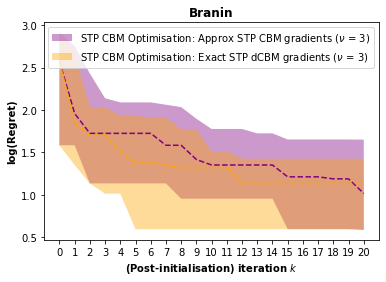

In [122]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple', ls='--')
plt.plot(median_exact, color = 'Orange', ls='--')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='STP CBM Optimisation: Approx STP CBM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='STP CBM Optimisation: Exact STP dCBM gradients ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(480.9251787662506, 425.5400855541229)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.mean(acqFuncExact_exact_1)
a1 = np.mean(acqFuncApprox_exact_1)

e1, a1


(5.214170660373789, 5.3638817725649455)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.mean(acqFuncExact_exact_2)
a2 = np.mean(acqFuncApprox_exact_2)

e2, a2


(5.351133122228431, 5.746839015500079)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.mean(acqFuncExact_exact_3)
a3 = np.mean(acqFuncApprox_exact_3)

e3, a3


(5.162190357254163, 5.544242659693567)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.mean(acqFuncExact_exact_4)
a4 = np.mean(acqFuncApprox_exact_4)

e4, a4


(5.079434703436453, 5.561954774955558)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.mean(acqFuncExact_exact_5)
a5 = np.mean(acqFuncApprox_exact_5)

e5, a5


(5.009210228161189, 5.445157916308748)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.mean(acqFuncExact_exact_6)
a6 = np.mean(acqFuncApprox_exact_6)

e6, a6


(5.336575185502801, 5.886629367228726)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.mean(acqFuncExact_exact_7)
a7 = np.mean(acqFuncApprox_exact_7)

e7, a7


(4.934976889928579, 5.260714986473987)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.mean(acqFuncExact_exact_8)
a8 = np.mean(acqFuncApprox_exact_8)

e8, a8


(5.317889394559671, 5.831722157423122)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.mean(acqFuncExact_exact_9)
a9 = np.mean(acqFuncApprox_exact_9)

e9, a9


(5.483240460790467, 5.574597285730009)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.mean(acqFuncExact_exact_10)
a10 = np.mean(acqFuncApprox_exact_10)

e10, a10


(5.2326039908859725, 5.724482135822305)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.mean(acqFuncExact_exact_11)
a11 = np.mean(acqFuncApprox_exact_11)

e11, a11


(5.310027531753303, 5.6992030449760955)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.mean(acqFuncExact_exact_12)
a12 = np.mean(acqFuncApprox_exact_12)

e12, a12


(5.037211957453716, 5.245521465847572)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.mean(acqFuncExact_exact_13)
a13 = np.mean(acqFuncApprox_exact_13)

e13, a13


(5.76927828068414, 5.970724534474757)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.mean(acqFuncExact_exact_14)
a14 = np.mean(acqFuncApprox_exact_14)

e14, a14


(4.8544122376727135, 5.23140352654707)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.mean(acqFuncExact_exact_15)
a15 = np.mean(acqFuncApprox_exact_15)

e15, a15


(5.121621898236354, 5.550445448086297)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.mean(acqFuncExact_exact_16)
a16 = np.mean(acqFuncApprox_exact_16)

e16, a16


(5.156728953970957, 5.521652803003657)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.mean(acqFuncExact_exact_17)
a17 = np.mean(acqFuncApprox_exact_17)

e17, a17


(5.311819418303678, 5.6408235250474155)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.mean(acqFuncExact_exact_18)
a18 = np.mean(acqFuncApprox_exact_18)

e18, a18


(5.096106681321813, 5.745113821404013)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.mean(acqFuncExact_exact_19)
a19 = np.mean(acqFuncApprox_exact_19)

e19, a19


(5.133592696834474, 5.52246876278904)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.mean(acqFuncExact_exact_20)
a20 = np.mean(acqFuncApprox_exact_20)

e20, a20


(5.532439409003735, 5.959619963199493)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(5.22223320291782, 5.601359948353822)

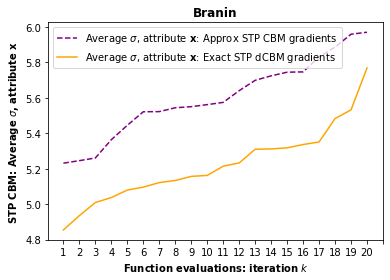

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Purple', ls='--', label='Average $\sigma$, attribute $\mathbf{x}$: Approx STP CBM gradients')
plt.plot(exact_stddev, color = 'Orange', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Function evaluations: iteration $\it{k}$', weight = 'bold')
plt.ylabel('STP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
